In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

## Модель и токенайзер

In [ ]:
from transformers import  LongT5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer,  AutoTokenizer

In [ ]:
model_checkpoint = "google/long-t5-tglobal-base"

model = LongT5ForConditionalGeneration.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Данные

In [ ]:
dataset = load_dataset("ccdv/govreport-summarization")
dataset['train'] = dataset['train'].shuffle(42).select(range(11000))

In [ ]:
dataset['train']

Dataset({
    features: ['report', 'summary'],
    num_rows: 11000
})

Отфильтруем данные, а именно train часть. Можно загнать все в токенизатор, но это займет много времени. Проще отфильтровать данные по словам: там, где набирается 1024 слова, гарантированно наберется минимум 1024 токена. (из расчета что в среднем 1 слово = 1,25 токен). Также распределения слов в документе и токенов будут совпадать.

In [ ]:
filtered_dataset_eda = dataset['train'].filter(lambda x: len(x['report'].split()) >= 1024)

In [ ]:
filtered_dataset_eda

Dataset({
    features: ['report', 'summary'],
    num_rows: 10929
})

Видим, что датасет, который мы выбрали, и так содержит тексты длиной больше чем 1024 - после фильтрации ушло всего 70 записей, что составляет 0.6 процента от общего количества.

## EDA

Минимальная длина: 1030
Максимальная длина: 181328
Средняя длина: 7724.645438740964
Медиана длины: 6433.0
Стандартное отклонение: 5850.284514409554
25-й процентиль: 4015.0
75-й процентиль: 9784.0


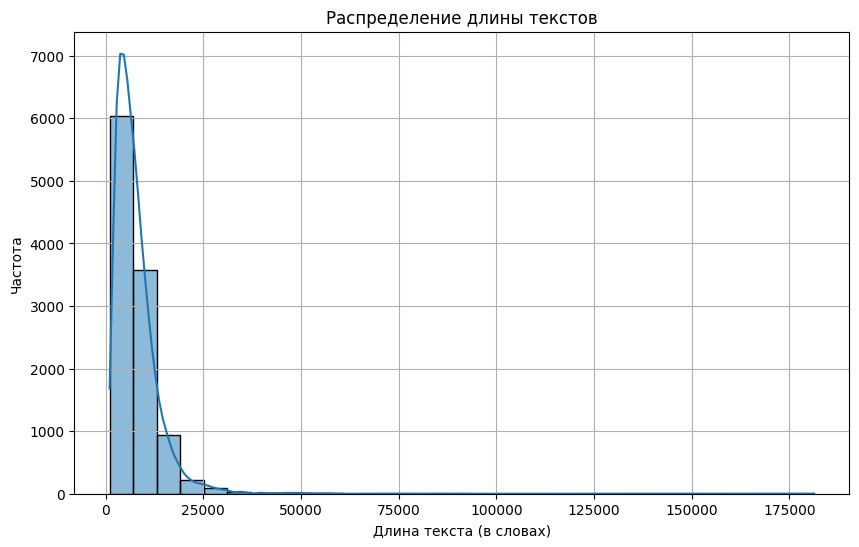

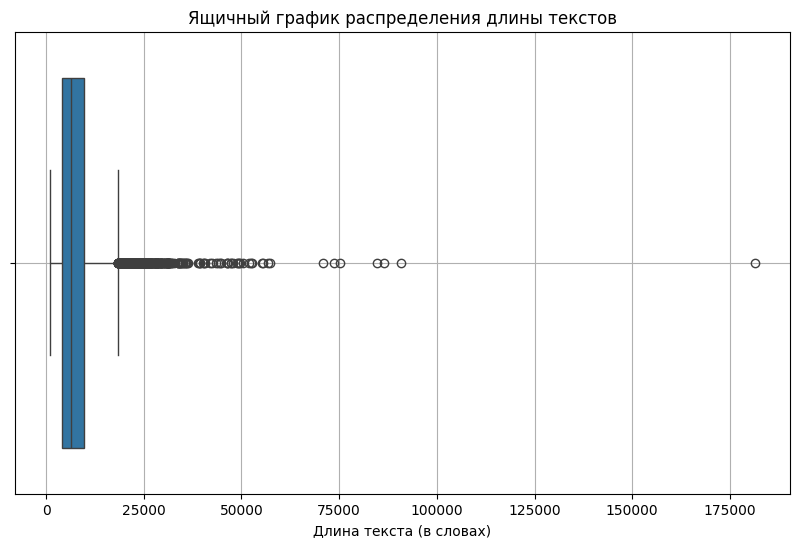

In [ ]:
lengths = [len(desc.split()) for desc in filtered_dataset_eda['report']]

min_length = np.min(lengths)
max_length = np.max(lengths)
mean_length = np.mean(lengths)
median_length = np.median(lengths)
std_length = np.std(lengths)
percentile_25 = np.percentile(lengths, 25)
percentile_75 = np.percentile(lengths, 75)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length}")
print(f"Медиана длины: {median_length}")
print(f"Стандартное отклонение: {std_length}")
print(f"25-й процентиль: {percentile_25}")
print(f"75-й процентиль: {percentile_75}")

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (в словах)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=lengths)
plt.title('Ящичный график распределения длины текстов')
plt.xlabel('Длина текста (в словах)')
plt.grid(True)
plt.show()

Вывод: видим, что распределение - экспоненциальное, типичное для длины текстов. Также видно, что есть выбросы, которые сильно отличаются от типичной длины датасета, они влияют на большую дисперсию и среднее. Удалим их, чтобы модель обучалась на более однородных данных (ну и смысла от них на обучении не будет, так как макс длина инупта модели - 16к токенов).

In [ ]:
filtered_dataset_final = filtered_dataset_eda.filter(lambda x: len(x['report'].split()) <= 15000)
filtered_dataset_final

Dataset({
    features: ['report', 'summary'],
    num_rows: 10051
})

Посмотрим на новое распределение:

Минимальная длина: 1030
Максимальная длина: 14994
Средняя длина: 6533.050343249428
Медиана длины: 5995.0
Стандартное отклонение: 3286.1933567102274
25-й процентиль: 3834.5
75-й процентиль: 8764.0


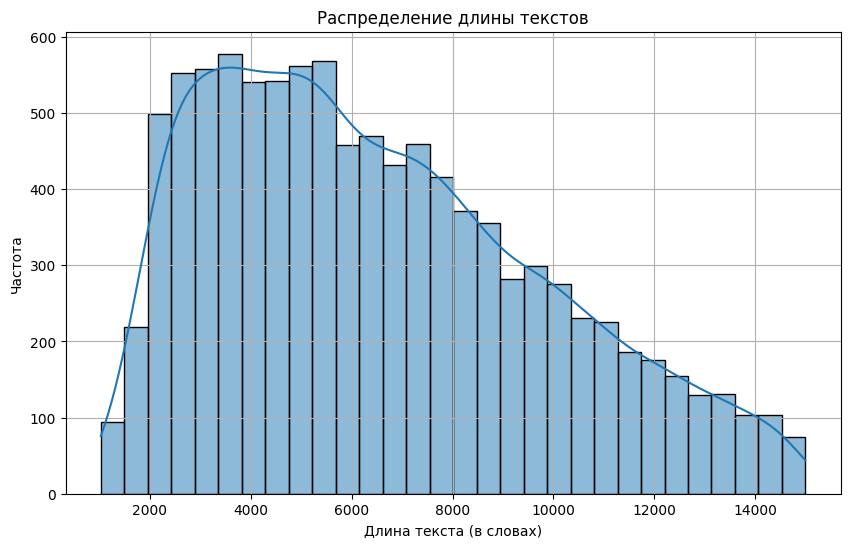

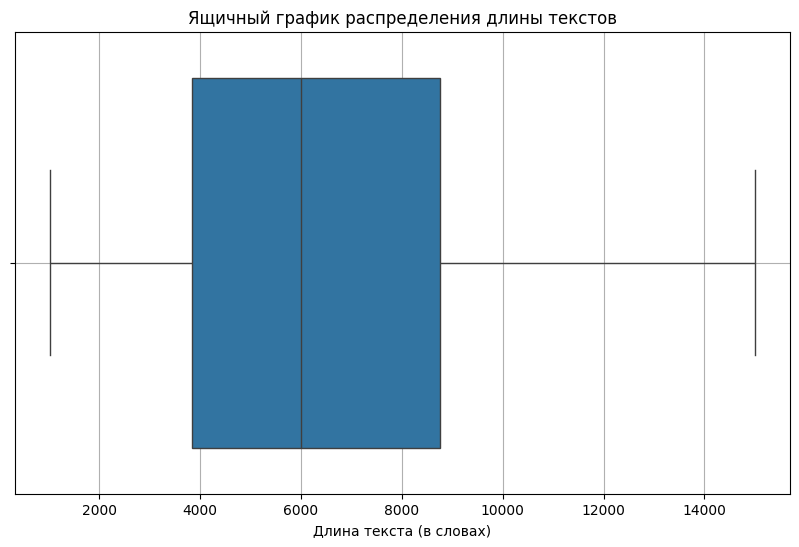

In [ ]:
lengths = [len(desc.split()) for desc in filtered_dataset_final['report']]

min_length = np.min(lengths)
max_length = np.max(lengths)
mean_length = np.mean(lengths)
median_length = np.median(lengths)
std_length = np.std(lengths)
percentile_25 = np.percentile(lengths, 25)
percentile_75 = np.percentile(lengths, 75)

print(f"Минимальная длина: {min_length}")
print(f"Максимальная длина: {max_length}")
print(f"Средняя длина: {mean_length}")
print(f"Медиана длины: {median_length}")
print(f"Стандартное отклонение: {std_length}")
print(f"25-й процентиль: {percentile_25}")
print(f"75-й процентиль: {percentile_75}")

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (в словах)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=lengths)
plt.title('Ящичный график распределения длины текстов')
plt.xlabel('Длина текста (в словах)')
plt.grid(True)
plt.show()

Так то лучше

## Препроцессинг данных

In [ ]:
import random

In [ ]:
max_input_length = 4096
max_target_length = 512

def preprocess_function(examples):
    inputs = [doc for doc in examples["report"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

посмотрим, как отрабатывает препроцессинг данных на примере одного текста:

In [ ]:
preprocess_function(filtered_dataset_final[random.randint(0, len(filtered_dataset_final))])

{'input_ids': [[272, 1], [3, 15, 1], [3, 75, 1], [3, 9, 1], [3, 76, 1], [3, 7, 1], [3, 15, 1], [1], [3, 32, 1], [3, 89, 1], [1], [3, 7, 1], [3, 76, 1], [3, 75, 1], [3, 107, 1], [1], [3, 15, 1], [3, 51, 1], [3, 15, 1], [3, 52, 1], [3, 122, 1], [3, 15, 1], [3, 29, 1], [3, 75, 1], [3, 23, 1], [3, 15, 1], [3, 7, 1], [1], [3, 9, 1], [3, 7, 1], [1], [3, 29, 1], [3, 9, 1], [3, 17, 1], [3, 76, 1], [3, 52, 1], [3, 9, 1], [3, 40, 1], [1], [3, 26, 1], [3, 23, 1], [3, 7, 1], [3, 9, 1], [3, 7, 1], [3, 17, 1], [3, 15, 1], [3, 52, 1], [3, 7, 1], [3, 6, 1], [1], [3, 107, 1], [3, 9, 1], [3, 172, 1], [3, 9, 1], [3, 52, 1], [3, 26, 1], [3, 32, 1], [3, 76, 1], [3, 7, 1], [1], [3, 51, 1], [3, 9, 1], [3, 17, 1], [3, 15, 1], [3, 52, 1], [3, 23, 1], [3, 9, 1], [3, 40, 1], [1], [3, 7, 1], [3, 102, 1], [3, 23, 1], [3, 40, 1], [3, 40, 1], [3, 7, 1], [3, 6, 1], [1], [3, 9, 1], [3, 29, 1], [3, 26, 1], [1], [3, 52, 1], [3, 23, 1], [3, 32, 1], [3, 17, 1], [3, 7, 1], [3, 6, 1], [1], [3, 9, 1], [3, 40, 1], [3, 40, 1],

In [ ]:
train_tokenized = filtered_dataset_final.map(preprocess_function, batched=True)
val_tokenized = dataset['validation'].map(preprocess_function, batched=True)
test_tokenized = dataset['test'].map(preprocess_function, batched=True)

Map:   0%|          | 0/10051 [00:00<?, ? examples/s]

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

код с метриками с HuggingFace:

In [ ]:
from evaluate import load
metric = load("rouge")

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

Не пугаемся, что метрики больше 1 - они будут показываться в процентах.

## Обучение

Датасет жирный, мощностей мало, поэтому посмотрим сначала способна ли вообще обучаться модель. Оставим 50 примеров в train и 50 в val.

In [ ]:
train_100 = filtered_dataset_final.shuffle(42).select(range(50)).map(preprocess_function, batched=True)
val_50 = dataset['validation'].shuffle(42).select(range(50)).map(preprocess_function, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Аргументы для обучения:

In [ ]:
batch_size = 1
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-small-100",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=False,
)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=train_100,
    eval_dataset=val_50,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,1.769323,5.169300,1.759700,4.379400,4.772600,19.000000
2,No log,1.779278,5.314400,1.920700,4.508500,4.875300,19.000000
3,No log,1.774173,5.464700,2.188600,4.686100,5.088500,19.000000
4,No log,1.769464,5.553500,2.199900,4.741400,5.140100,19.000000
5,No log,1.778052,5.575800,2.272300,4.771100,5.180200,19.000000
6,No log,1.781429,5.642000,2.380800,4.821100,5.230200,19.000000
7,No log,1.772721,5.886500,2.682000,5.064300,5.508800,19.000000
8,No log,1.777231,5.830200,2.636400,5.000900,5.466900,19.000000
9,No log,1.778986,5.901400,2.662900,5.072400,5.538300,19.000000
10,2.344500,1.777026,5.871600,2.662900,5.043800,5.520900,19.000000


TrainOutput(global_step=500, training_loss=2.344504150390625, metrics={'train_runtime': 460.1123, 'train_samples_per_second': 1.087, 'train_steps_per_second': 1.087, 'total_flos': 2612497432320000.0, 'train_loss': 2.344504150390625, 'epoch': 10.0})

Видно, что процесс обучения идет, все метрики растут. Но все со скрипом - в память влезает только один батч, в fp16 модель перевести не получилось. Макс длину последовательности пришлось огранить до 4096. В общем нормально потюнить на этом датасете, да и получить какие то большие значения метрик не получится, хоть мы и пытались. ЧТобы показать, что мы все делаем корректно, запустим модель на другом датасете.

In [ ]:
xsum_dataset = load_dataset("xsum")
xsum_dataset['train'] = xsum_dataset['train'].filter(lambda x: len(x['document'].split()) > 1000 and len(x['document'].split()) < 10000).shuffle(seed=42).select(range(1000))
xsum_dataset['validation'] = xsum_dataset['validation'].shuffle(seed=42).select(range(100))
xsum_dataset['test'] = xsum_dataset['test'].shuffle(seed=42).select(range(100))

In [ ]:
max_input_length = 4096
max_target_length = 256

def preprocess_function(examples):
    inputs = [doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = xsum_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
batch_size = 1
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
)

In [ ]:
model_xsum = LongT5ForConditionalGeneration.from_pretrained(model_checkpoint)

In [ ]:
trainer_xsum = Seq2SeqTrainer(
    model_xsum,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer_xsum.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.975400,2.170736,24.691000,7.551700,20.153700,20.089200,18.380000
2,2.763300,2.092294,26.290100,8.323200,21.169900,21.094700,18.520000
3,2.635900,2.084372,27.013900,8.518100,21.671900,21.649500,18.490000


TrainOutput(global_step=3000, training_loss=2.8406467692057293, metrics={'train_runtime': 840.511, 'train_samples_per_second': 3.569, 'train_steps_per_second': 3.569, 'total_flos': 7299302926464000.0, 'train_loss': 2.8406467692057293, 'epoch': 3.0})

Точно все окей, все завелось. Но мощности уже подходят к концу, поэтому обучение было всего на 1000 примерах.

Посмотрим как прошла саммаризация для 10 примеров:

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model=model_xsum, tokenizer=tokenizer)

def generate_summary(text):
    return summarizer(text, max_length=256, min_length=128, do_sample=False)[0]['summary_text']

In [ ]:


#random 10 samples
for i in range(10):
    sample = xsum_dataset['validation'][random.randint(0, 100)]
    print(f"Document: {sample['document']}")
    print(f"Reference summary: {sample['summary']}")
    print(f"Generated summary: {generate_summary(sample['document'])}")
    print()


Document: West Midlands PC Zaid Malik was off duty when he got into an argument with another driver in Birmingham.
He convinced friend Roger Baker, 50, to provide a false alibi. Both denied a charge of conspiracy to pervert the course of justice.
Malik, 51, of Sparkhill and Baker, 50, of Acocks Green, were jailed for 21 months and 12 months respectively.
See more stories from across Birmingham and the Black Country here
West Midlands Police said the incident took place in Stechford on 26 February 2015.
The force said witnesses accused the former Coventry-based PC of being the aggressor, but police decided not to press charges when a seemingly independent account from Baker backed Malik's claim he was the innocent party.
Police said investigators became suspicious after revealing inconsistencies in the men's statements. They discovered the two were friends and Baker, of Westfield Road, had not been at the scene of the dispute.
Both men were found guilty following a trial and sentenced o

Your max_length is set to 256, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


Generated summary: Zayn Malik has announced that he is leaving One Direction after five years. Abbie, Nottinghamshire, England I think that Zayn made the right decision to leave One Direction, even though I'll be very sad to see him leave!..I'm glad to see Zayn go..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave..I'm glad to see him leave

Document: The Vulcan XH558 took part in the North Wales Air Show at Rhyl, Denbighshire, on Saturday as part of a final series of displays which end in September.
More than 180,000 people are expected at the air show over 

Довольно адекватно, но многословно. Видно, что обучение получилось.

# Подход "кроим-сшиваем"

In [ ]:
from transformers import T5Tokenizer

In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0")
tokenizer = AutoTokenizer.from_pretrained("t5-small")

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

разбиение и токенизация:

In [ ]:
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split

In [ ]:
dataset['train'] = dataset["train"].select(range(20000))

In [ ]:
def split_text(text, max_length=512):
    sentences = sent_tokenize(text)
    current_length = 0
    part1, part2 = [], []
    for sent in sentences:
        tokenized_len = len(tokenizer.encode(sent, add_special_tokens=False))
        if current_length + tokenized_len <= max_length:
            part1.append(sent)
            current_length += tokenized_len
        else:
            part2.append(sent)
    return " ".join(part1), " ".join(part2)

def preprocess_data(dataset, tokenizer):
    inputs, targets = [], []
    for item in dataset:
        part1, part2 = split_text(item['article'])
        inputs.append(part1)
        inputs.append(part2)
        targets.append(item['highlights'])
        targets.append(item['highlights'])
    return inputs, targets

train_articles, test_articles = train_test_split(dataset['train']['article'], test_size=0.1, shuffle=False)
train_targets, test_targets = train_test_split(dataset['train']['highlights'], test_size=0.1, shuffle=False)

train_inputs, train_targets = preprocess_data(
    [{'article': article, 'highlights': highlight} for article, highlight in zip(train_articles, train_targets)], tokenizer
)
test_inputs, test_targets = preprocess_data(
    [{'article': article, 'highlights': highlight} for article, highlight in zip(test_articles, test_targets)], tokenizer
)

In [ ]:
def tokenize_function(inputs, targets, tokenizer, max_length=512):
    input_encodings = tokenizer(inputs, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    target_encodings = tokenizer(targets, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    return input_encodings, target_encodings

train_encodings, train_labels = tokenize_function(train_inputs, train_targets, tokenizer)
test_encodings, test_labels = tokenize_function(test_inputs, test_targets, tokenizer)

In [ ]:
import torch
class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels["input_ids"][idx])
        return item

train_dataset = SummarizationDataset(train_encodings, train_labels)
test_dataset = SummarizationDataset(test_encodings, test_labels)

In [ ]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

model = T5ForConditionalGeneration.from_pretrained("t5-small")
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.488100,1.235964
2,1.459700,1.227534
3,1.446400,1.224857


TrainOutput(global_step=10800, training_loss=1.496997149432147, metrics={'train_runtime': 1436.4929, 'train_samples_per_second': 75.183, 'train_steps_per_second': 7.518, 'total_flos': 1.4616914558976e+16, 'train_loss': 1.496997149432147, 'epoch': 3.0})

Подход работает, лосс падает. Посмотрим на результаты:

In [ ]:
def generate_summary(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True).input_ids.to("cuda")
    outputs = model.generate(inputs, max_length=150, num_beams=4, early_stopping=True).to("cuda")
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def combine_summaries(text1, text2):
    return f"{text1} {text2}"

In [ ]:
test_texts = test_articles[:10]
generated_summaries = []
for text in test_texts:
    part1, part2 = split_text(text)
    summary1 = generate_summary(part1, tokenizer, model)
    summary2 = generate_summary(part2, tokenizer, model)
    combined_summary = combine_summaries(summary1, summary2)
    generated_summaries.append(combined_summary)


In [ ]:
test_texts

['New York (CNN) -- He was one cool cat, trekking half way across America before meeting an untimely death by car on a Connecticut parkway. The 1,500-mile feline journey is a "testament to the wonders of nature and the tenacity" of the species, said Daniel Esty, commissioner of Connecticut\'s Department of Energy and Environmental Protection. It was one of the longest known movements ever recorded for a land mammal and nearly double the distance for a mountain lion, the agency said. There had been sightings of the large cat in Greenwich, Connecticut, its presence an anomaly in a state where none has been seen in more than a century. Sadly, it was the cat\'s death that helped tie everything together. A 2006 Hyundai Tucson SUV hit and killed the animal in the very early hours of June 11. Police were informed of a collision between a vehicle and a mountain lion in the northbound lane, near exit 55, of Wilbur Cross Parkway in Milford. A necropsy and genetic tests revealed the lion\'s origi

In [ ]:
generated_summaries

['The cat was one of the longest known movements ever recorded for a land mammal. It was nearly double the distance for a mountain lion. A 2006 Hyundai Tucson SUV hit and killed the animal in the early hours of June 11. NEW: "It\'s a good thing to be able to do it," he says. NEW: "It\'s a good thing to be able to do it," he says. NEW: "It\'s a good thing to be able to do it," he says. NEW: "It\'s a good thing to be able to do it," he says.',
 'Barcelona agree to sell Bojan Krkic to Italian club Roma for $17.3 million. Barcelona have an option to buy back the 20-year-old for $18.7 million at the end of the 2012-13 season. Barcelona have an option to buy back the 20-year-old for $18.7 million at the end of the 2012-13 season. Turkish club Galatasaray announce the signing of Brazilian midfielder Felipe Melo. The 28-year-old joins Johan Elmander and Fernando Muslera in the Istanbul team. Melo is on a season-long loan from Italian side Juventus.',
 'Disney\'s family comedy "G-Force" made an

In [ ]:
metric = load("rouge")
results = metric.compute(predictions=generated_summaries, references=test_targets[:10])

print("ROUGE метрики:", results)

print("\nПримеры саммари:")
for i, summary in enumerate(generated_summaries[:3]):
    print(f"Текст {i+1}:\n", summary)

ROUGE метрики: {'rouge1': 0.12896579423554774, 'rouge2': 0.012847011144883486, 'rougeL': 0.08905924384750102, 'rougeLsum': 0.1146078434027582}

Примеры саммари:
Текст 1:
 The cat was one of the longest known movements ever recorded for a land mammal. It was nearly double the distance for a mountain lion. A 2006 Hyundai Tucson SUV hit and killed the animal in the early hours of June 11. NEW: "It's a good thing to be able to do it," he says. NEW: "It's a good thing to be able to do it," he says. NEW: "It's a good thing to be able to do it," he says. NEW: "It's a good thing to be able to do it," he says.
Текст 2:
 Barcelona agree to sell Bojan Krkic to Italian club Roma for $17.3 million. Barcelona have an option to buy back the 20-year-old for $18.7 million at the end of the 2012-13 season. Barcelona have an option to buy back the 20-year-old for $18.7 million at the end of the 2012-13 season. Turkish club Galatasaray announce the signing of Brazilian midfielder Felipe Melo. The 28-year-

Метрики не очень хорошие, но не нулевые. Для проверки работоспособности подхода, конечно нужно обучать на всем датасете